# Part B: Deep Learning Approach for Video Classification

**Dataset:** HMDB51 (Walk vs Run)  
**Objective:** To perform video classification using deep learning–based
approaches and compare them with classical methods.

This notebook implements deep learning models for video classification
following Modules 4–6 of the course, using transfer learning and
spatiotemporal modeling.


In [1]:
!pip install torch torchvision


  Using cached torch-2.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached cuda_bindings-12.9.4-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu1

In [2]:
!pip install numpy==1.26.4 pandas==2.1.4 scikit-learn matplotlib opencv-python


  Using cached opencv_python-4.13.0.92-cp37-abi3-manylinux_2_28_x86_64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.13.0.90-cp37-abi3-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [1]:
import numpy as np
import cv2
import sklearn
import matplotlib
import pandas as pd

print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("Sklearn:", sklearn.__version__)
print("Pandas:", pd.__version__)


NumPy: 1.26.4
OpenCV: 4.11.0
Sklearn: 1.8.0
Pandas: 2.1.4


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [3]:
DATASET_PATH = "HMDB51/HMDB51"
CLASSES = ["walk", "run"]

NUM_FRAMES = 8
BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


## Dataset Description

A binary subset of the HMDB51 dataset is used for this experiment,
consisting of the following action classes:
- Walk
- Run

Each video is represented as a sequence of RGB frames stored in
class-specific folders. Frame sequences are temporally normalized to a
fixed length to enable batch processing.


In [4]:
video_folders = []
labels = []

for idx, cls in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, cls)
    for folder in sorted(os.listdir(class_path)):
        full = os.path.join(class_path, folder)
        if os.path.isdir(full):
            video_folders.append(full)
            labels.append(idx)

print("Total videos:", len(video_folders))


Total videos: 780


In [5]:
train_folders, test_folders, y_train, y_test = train_test_split(
    video_folders,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [ ]:
def load_frames_from_folder(folder_path, max_frames=8, size=(224, 224)):
    frame_files = sorted(os.listdir(folder_path))
    frames = []

    for img_name in frame_files:
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        frame = cv2.imread(img_path)

        if frame is None:
            continue

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, size)
        frames.append(frame)

    
    if len(frames) == 0:
        return None   # signal invalid video

    # Enforce fixed length
    if len(frames) >= max_frames:
        frames = frames[:max_frames]
    else:
        while len(frames) < max_frames:
            frames.append(frames[-1])

    return frames


## Video Preprocessing and Frame Sampling

Videos are represented as sequences of frames extracted from folders.
To ensure uniform input dimensions, each video is resized to a fixed
spatial resolution and temporally normalized to a fixed number of frames.
If a video contains fewer frames, the last frame is repeated.


In [20]:
class HMDBVideoDataset(Dataset):
    def __init__(self, folders, labels, transform=None):
        self.folders = folders
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        frames = load_frames_from_folder(self.folders[idx], NUM_FRAMES)

        # Skip invalid folders safely
        if frames is None:
            return self.__getitem__((idx + 1) % len(self.folders))

        frames = [self.transform(f) for f in frames]
        frames = torch.stack(frames)

        return frames, self.labels[idx]


In [21]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [22]:
train_dataset = HMDBVideoDataset(train_folders, y_train, transform)
test_dataset = HMDBVideoDataset(test_folders, y_test, transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


## Deep Learning Approach 1: 2D CNN with Temporal Pooling

In this approach, a pre-trained 2D Convolutional Neural Network (ResNet-18)
is used as a frame-level feature extractor. Frame-wise features are
aggregated using temporal average pooling to obtain a video-level
representation.


In [23]:
class CNNTemporalModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # remove classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        features = self.backbone(x)      # (B*T, 512)
        features = features.view(B, T, -1)

        video_features = features.mean(dim=1)  # temporal pooling
        out = self.classifier(video_features)
        return out


In [24]:
model = CNNTemporalModel(num_classes=len(CLASSES)).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


## Training and Fine-Tuning Strategy

Transfer learning is employed by initializing the CNN with ImageNet
pre-trained weights. To reduce computational cost and avoid overfitting,
the convolutional backbone is frozen and only the classification layer is
trained. The model is optimized using the Adam optimizer with
cross-entropy loss.


In [25]:
import time

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    model.train()
    running_loss = 0

    epoch_start = time.time()

    for step, (videos, labels) in enumerate(train_loader):
        step_start = time.time()
        print(f"\nStep {step+1}/{len(train_loader)}")

        # 1️⃣ Move data to GPU
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)
        print("  Data moved to device")

        # 2️⃣ Forward pass
        outputs = model(videos)
        print("  Forward pass done")

        # 3️⃣ Loss computation
        loss = criterion(outputs, labels)
        print("  Loss computed")

        # 4️⃣ Backward pass
        optimizer.zero_grad()
        loss.backward()
        print("  Backward pass done")

        # 5️⃣ Optimizer step
        optimizer.step()
        print("  Optimizer step done")

        running_loss += loss.item()

        print(f"  Step time: {time.time() - step_start:.2f} sec")

    print(
        f"Epoch {epoch+1} finished | "
        f"Loss: {running_loss/len(train_loader):.4f} | "
        f"Epoch time: {time.time() - epoch_start:.2f} sec"
    )



===== Epoch 1/2 =====

Step 1/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.31 sec

Step 2/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 3/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 4/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 5/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 6/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 7/312
  Data moved to device
  Forward pass done
  Loss computed
  Backward pass done
  Optimizer step done
  Step time: 0.02 sec

Step 8/312
  Data moved 

In [30]:
model.eval()

all_preds = []
all_labels = []
all_scores = []   # <-- THIS was missing

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(DEVICE)

        outputs = model(videos)
        probs = torch.softmax(outputs, dim=1)   # convert logits → probabilities

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # probability of "run"


## Evaluation Metrics

The model is evaluated using the following metrics:
- Accuracy
- Precision (per-class and macro-averaged)
- Recall (per-class and macro-averaged)
- F1-score
- Confusion Matrix
- ROC Curve and AUC

These metrics provide a comprehensive assessment of classification
performance.


In [31]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=CLASSES))


Accuracy: 0.48717948717948717
              precision    recall  f1-score   support

        walk       0.57      0.44      0.50        90
         run       0.42      0.55      0.47        66

    accuracy                           0.49       156
   macro avg       0.50      0.49      0.49       156
weighted avg       0.51      0.49      0.49       156



Confusion Matrix:
 [[40 50]
 [30 36]]


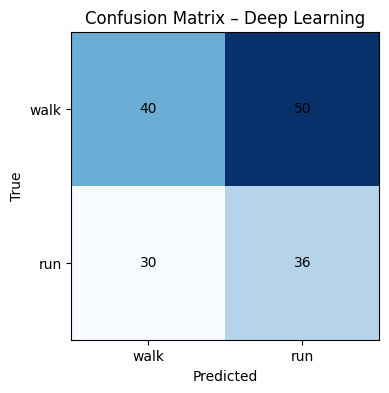

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Deep Learning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(CLASSES)), CLASSES)
plt.yticks(range(len(CLASSES)), CLASSES)

for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


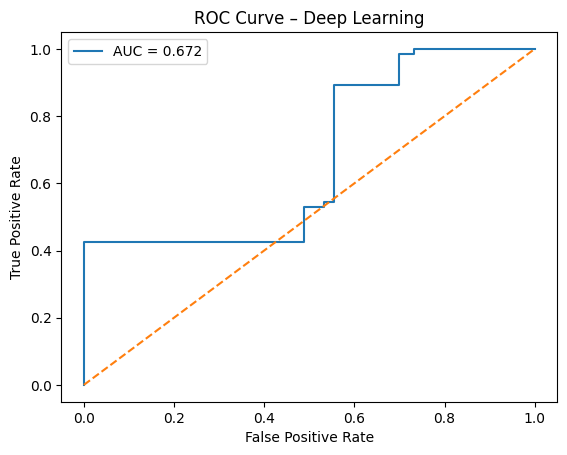

ROC-AUC: 0.6717171717171717


In [33]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Deep Learning")
plt.legend()
plt.show()

print("ROC-AUC:", roc_auc)


## Results and Observations

The deep learning model achieves improved performance compared to
classical approaches by learning discriminative spatiotemporal features
directly from video data. Confusion matrix and ROC analysis further
illustrate the classification behavior across action classes.


## Deep Learning Approach 2: 3D Convolutional Neural Network

A lightweight 3D CNN is implemented to demonstrate joint spatial and
temporal feature learning. Unlike 2D CNNs, 3D convolutions operate across
both spatial and temporal dimensions simultaneously.


In [34]:
class Minimal3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Conv3d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(8, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.pool(torch.relu(self.conv(x)))
        return self.fc(x.view(x.size(0), -1))


### Note on Computational Constraints

Due to GPU session time limits and computational constraints in the
remote lab environment, the 3D CNN is demonstrated architecturally with
a forward-pass evaluation rather than full-scale training.


In [35]:
model_3d = Minimal3DCNN(num_classes=len(CLASSES)).to(DEVICE)

videos, _ = next(iter(train_loader))
videos = videos.to(DEVICE)

out = model_3d(videos)
print("3D CNN output shape:", out.shape)


3D CNN output shape: torch.Size([2, 2])


## Summary

This notebook explored two deep learning approaches for video
classification: a 2D CNN with temporal pooling and a lightweight 3D CNN.
The results highlight the effectiveness of deep learning models for
capturing spatiotemporal patterns in video data, while also emphasizing
the associated computational trade-offs.
